In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
import os
import cv2
from skimage import io
from torchvision import transforms
import torch.nn.functional as F
import skimage
from models import Net
from data_load import Normalize,RandomCrop,Rescale,FaceData,ToTensor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
train_csv = 'data/training_frames_keypoints.csv'
train_dir = 'data/training'
test_csv = 'data/test_frames_keypoints.csv'
test_dir = 'data/test'


## Loading train and test data

In [8]:
transform_ = transforms.Compose([Rescale(250),
                                    RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])



train_dataset = FaceData(point_file=train_csv,image_folder=train_dir,transform=transform_)
print('Length of dataset: ', len(train_dataset))
test_dataset = FaceData(test_csv,test_dir,transform_)
print('Length of dataset: ', len(test_dataset))


Length of dataset:  3462
Length of dataset:  770


In [9]:
for data in test_dataset:
  print(data['image'].shape)
  print(data['keypoints'].shape)
  break

torch.Size([1, 224, 224])
torch.Size([68, 2])


In [10]:
for data in train_dataset:
  print(data['image'].shape)
  print(data['keypoints'].shape)
  break

torch.Size([1, 224, 224])
torch.Size([68, 2])


## Loading in batches

In [0]:

# tr = int(0.8*len(face_dataset))
# val = len(face_dataset) - int(0.8*len(face_dataset))
# trainset, valset = random_split(face_dataset, [tr,val])

train_loader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=5)

In [12]:
for data in test_loader:
  print(data['image'].shape)
  print(data['keypoints'].shape)
  break

torch.Size([5, 1, 224, 224])
torch.Size([5, 68, 2])


# Model Creation

In [13]:
model = Net()
model = model.to(device)
model

Net(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=136, bias=True)
)

## Loading saved model

In [14]:
state_dict = torch.load('model_may14.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

## Prediction and visualization

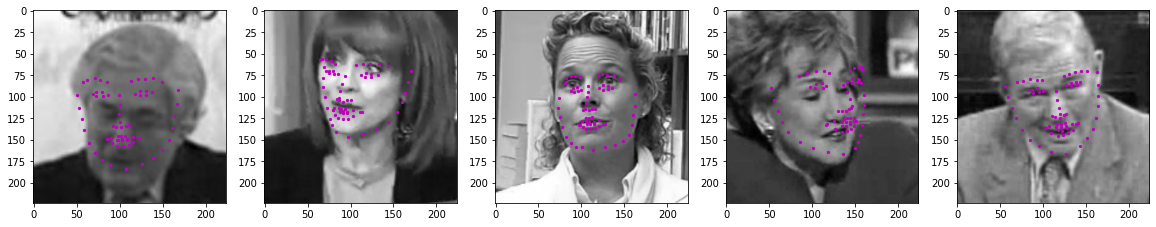

In [16]:
model.eval()
data_ = iter(test_loader)
data = next(data_)
images = data['image']
images = images.to(device,dtype=torch.float)
out = model(images)


def image_kpconvert(image,kpts):
    kpts = kpts.view(68,-1)
    kpts = kpts.cpu().detach().numpy()
    kpts = (kpts*50) + 100 #denormalize keypoints
    image = image.cpu().detach().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image,kpts


def plot_img(image,key_pts):
    plt.imshow(np.squeeze(image),cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

plt.figure(figsize=(20,18))
for i in range(5):
    plt.subplot(1,5,i+1)
    img,kp = image_kpconvert(images[i],out[i])
    plot_img(img,kp)


## Feature visualization

In [17]:
weights1 = model.conv1.weight.data

w = weights1.cpu().numpy()
# we can see that we have 32 feature outputs in first layer so we have shape of (32,1,5,5)
w.shape

(32, 1, 5, 5)

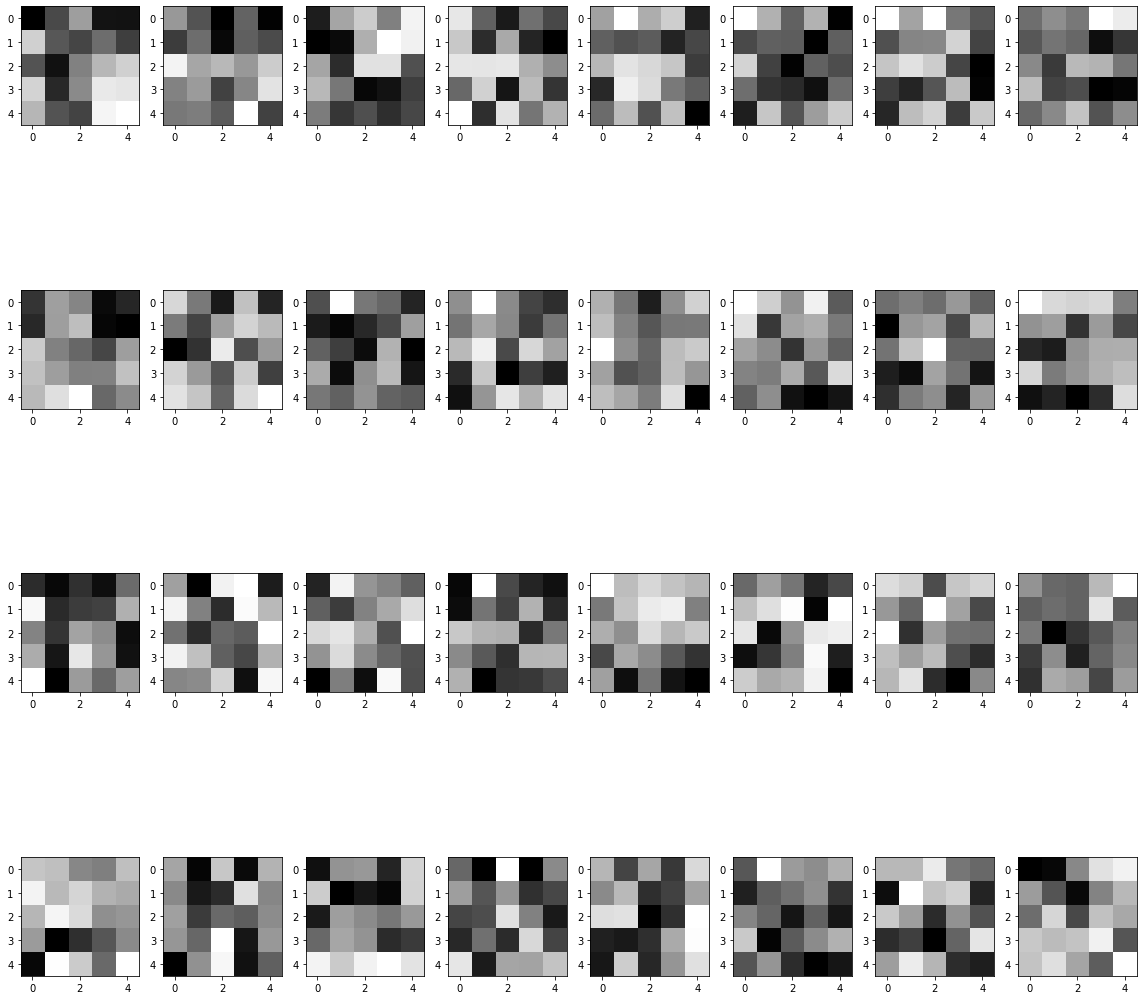

In [18]:
# we will visua;ize these feature maps
plt.figure(figsize = (20,20))
for i in range(32):
   weight = w[i][0]
   plt.subplot(4,8,i+1)
   plt.imshow(weight,cmap='gray')

## Now we will choose one filter from your trained CNN and apply it to a validation image and will see what happens

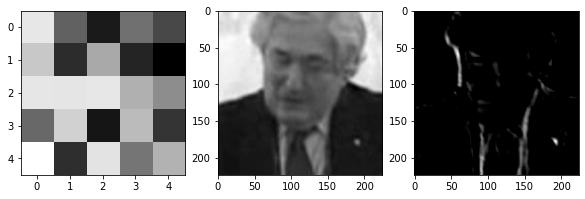

In [24]:
plt.figure(figsize=(10,10))

weight = w[3][0]
plt.subplot(1,3,1)
plt.imshow(weight,cmap='gray')


img = test_dataset[0]['image']
image = img.cpu().detach().numpy()
image = image.transpose((1,2,0))
image = (image * 255).astype(np.uint8)
image = np.squeeze(image)
plt.subplot(1,3,2)
plt.imshow(image,cmap='gray')

filtered = cv2.filter2D(image, -1, weight)
plt.subplot(1,3,3)
plt.imshow(filtered,cmap='gray')
plt.show()

Here we can see it is detecting vertical lines.It is most probabily a high pass filter.